# Generating a graph layout for the Hemibrain data
> Here I use some of our layout tools to plot a 2D representation of the Hemibrain Fly Connectome.
  dataset.

- toc: true
- badges: true
- comments: true
- categories: [pedigo, graspologic, connectome]
- hide: false
- search_exclude: false

 ## Load the data
 Data is from the paper:

 ```
 @article{xu2020connectome,
  title={A connectome of the adult drosophila central brain},
  author={Xu, C Shan and Januszewski, Michal and Lu, Zhiyuan and Takemura, Shin-ya and Hayworth, Kenneth and Huang, Gary and Shinomiya, Kazunori and Maitin-Shepard, Jeremy and Ackerman, David and Berg, Stuart and others},
  journal={BioRxiv},
  year={2020},
  publisher={Cold Spring Harbor Laboratory}
 }
 ```

In [1]:
import time
import datetime
from pathlib import Path
import pandas as pd
import networkx as nx
from giskard.plot import graphplot
from graspologic.partition import leiden
from graspologic.layouts.colors import _get_colors
import numpy as np
from graspologic.partition import hierarchical_leiden, HierarchicalCluster
from src.io import savefig
from sklearn.model_selection import ParameterGrid

t0 = time.time()

main_random_state = np.random.default_rng(8888)


def stashfig(name):
    savefig(name, foldername="hemibrain-layout")


# TODO this is a bit buried in graspologic, should expose it more explicitly
colors = _get_colors(True, None)["nominal"]

data_path = Path("maggot_models/data/raw/exported-traced-adjacencies-v1.1")

neuron_file = "traced-neurons.csv"
edgelist_file = "traced-total-connections.csv"

edgelist_df = pd.read_csv(data_path / edgelist_file)

g = nx.from_pandas_edgelist(
    edgelist_df,
    source="bodyId_pre",
    target="bodyId_post",
    edge_attr="weight",
    create_using=nx.DiGraph,
)


 ## Run community detection for coloring the network

In [2]:


def symmetrze_nx(g):
    """Leiden requires a symmetric/undirected graph. This converts a directed graph to
    undirected just for this community detection step"""
    sym_g = nx.Graph()
    for source, target, weight in g.edges.data("weight"):
        if sym_g.has_edge(source, target):
            sym_g[source][target]["weight"] = (
                sym_g[source][target]["weight"] + weight * 0.5
            )
        else:
            sym_g.add_edge(source, target, weight=weight * 0.5)
    return sym_g


sym_g = symmetrze_nx(g)
leiden_mode = "flat"
if leiden_mode == "hierarchical":
    hierarchical_partition = hierarchical_leiden(
        sym_g,
        check_directed=False,
        max_cluster_size=300,
        random_seed=int(main_random_state.integers(np.iinfo(np.int32).max)),
    )
    partition_map = HierarchicalCluster.final_hierarchical_clustering(
        hierarchical_partition
    )
elif leiden_mode == "flat":
    partition_map = leiden(
        sym_g,
        resolution=3,
        random_seed=int(main_random_state.integers(np.iinfo(np.int32).max)),
    )
print(f"Number of unique partitions: {len(np.unique(list(partition_map.values())))}")

# Define the color map
nx.set_node_attributes(g, partition_map, name="partition")
palette = dict(zip(np.unique(list(partition_map.values())), colors))


Number of unique partitions: 31


 ## Sweep over some parameters for plotting (optional)

In [3]:
sweep_params = False
plot_kws = dict(
    edge_linewidth=0.1,
    edge_alpha=0.1,
    subsample_edges=0.05,
    palette=palette,
    figsize=(12, 12),
    sizes=(3, 10),
)
param_grid = {
    "embedding_algorithm": ["ase", "lse"],
    "n_neighbors": [16, 32, 64],
    "n_components": [8, 16, 32, 64],
}


def dict_to_str(dictionary):
    out = ""
    for key, value in dictionary.items():
        out += f"-{key}={value}"
    return out


if sweep_params:
    param_list = list(ParameterGrid(param_grid))
else:
    param_list = []
for embed_params in param_list:
    currtime = time.time()
    random_seed = main_random_state.integers(np.iinfo(np.int32).max)
    random_state = np.random.default_rng(random_seed)
    graphplot(
        g,
        hue="partition",
        verbose=1,
        random_state=random_state,
        **embed_params,
        **plot_kws,
    )
    stashfig(f"hemibrain-graphplot{dict_to_str(embed_params)}")
    print(f"{time.time() - currtime:.3f} seconds elapsed to run layout.")
    print()


 ## Plot my favorite layout
 Running this a few times just because it's a randomized algorithm.

Performing initial spectral embedding of the network...
Performing UMAP embedding...
Scatterplotting nodes...
Collating edge data for plotting...
Subsampling edges...
Mapping edge data for plotting...
Plotting edges...
Saved figure to maggot_models/notebooks/outs/hemibrain-layout/figs/hemibrain-graphplot-n_components=64-n_neighbors=64-embedding_algorithm=lse-seed=543918345.png
Performing initial spectral embedding of the network...
Performing UMAP embedding...
Scatterplotting nodes...
Collating edge data for plotting...
Subsampling edges...
Mapping edge data for plotting...
Plotting edges...
Saved figure to maggot_models/notebooks/outs/hemibrain-layout/figs/hemibrain-graphplot-n_components=64-n_neighbors=64-embedding_algorithm=lse-seed=1404150835.png
Performing initial spectral embedding of the network...
Performing UMAP embedding...
Scatterplotting nodes...
Collating edge data for plotting...
Subsampling edges...
Mapping edge data for plotting...
Plotting edges...
Saved figure to magg

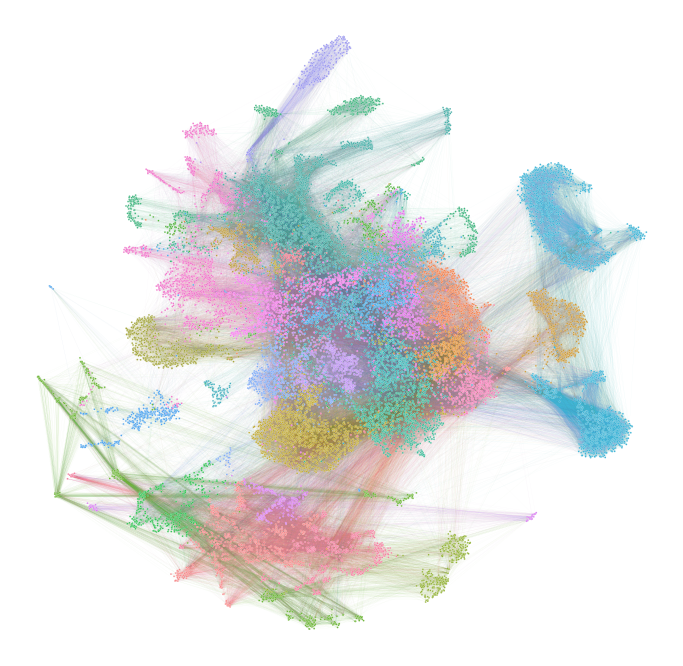

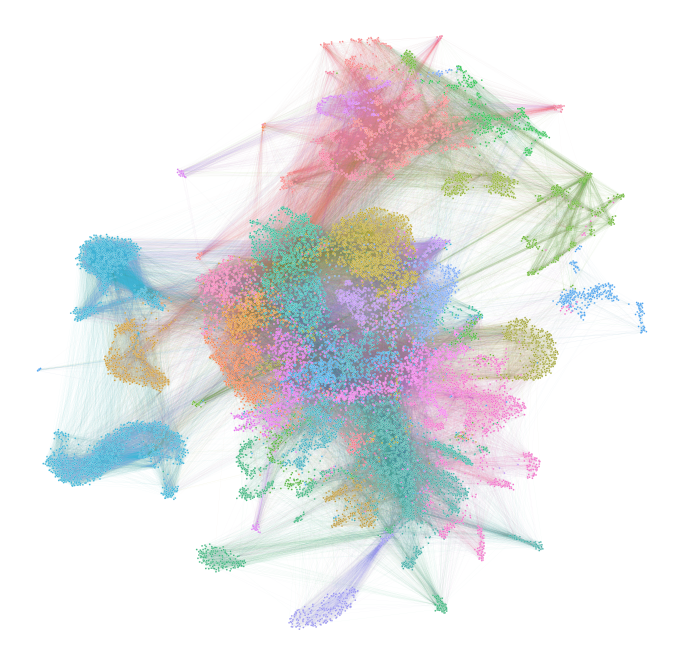

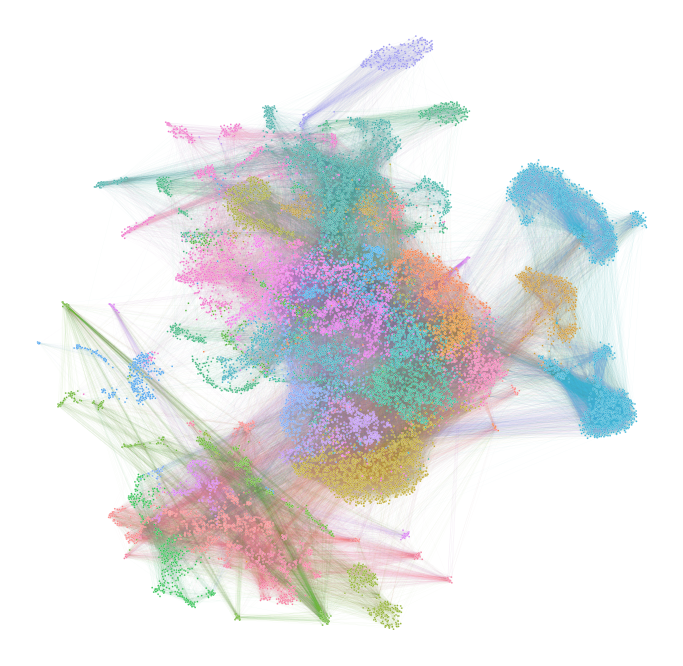

In [4]:
embed_params = dict(n_components=64, n_neighbors=64, embedding_algorithm="lse")
for i in range(3):
    random_seed = main_random_state.integers(np.iinfo(np.int32).max)
    random_state = np.random.default_rng(random_seed)
    graphplot(
        g,
        hue="partition",
        verbose=1,
        random_state=random_state,
        **embed_params,
        **plot_kws,
    )
    stashfig(f"hemibrain-graphplot{dict_to_str(embed_params)}-seed={random_seed}")


 ## End

In [5]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")


----
Script took 0:05:49.716836
Completed at 2021-05-06 11:57:36.585274
----
